In [1]:
!pip install einops
!pip install bitsandbytes

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [25]:
!pip install timm flash_attn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import cv2
import matplotlib.pyplot as plt
import bitsandbytes

In [4]:
pwd

'/home/csegpuserver/Kushagra'

In [3]:
cd ..

/home/csegpuserver/Kushagra


In [6]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM 


device = "cuda:1" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained("model_checkpoints/epoch_5", torch_dtype=torch.float16, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("model_checkpoints/epoch_5", trust_remote_code=True)



In [7]:
prompt = "<OD>"
text = "tanks"
url = "https://imageio.forbes.com/specials-images/imageserve/5ee6b28ac0e4020006640318//0x0.jpg?format=jpg&crop=3000,1407,x0,y451,safe&width=1440"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=text, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

print(parsed_answer)


{'<OD>': {'bboxes': [[955.4400634765625, 348.63751220703125, 1439.280029296875, 531.5625], [955.4400634765625, 327.0375061035156, 1194.4801025390625, 477.5625], [1321.2000732421875, 234.5625, 1439.280029296875, 367.5375061035156], [1324.080078125, 287.88751220703125, 1439.280029296875, 367.5375061035156]], 'labels': ['ArtilleryTank', 'TankTankTank', 'TankTank', 'TankTank']}}


In [8]:
bboxes=parsed_answer['<OD>']['bboxes']
labels= parsed_answer['<OD>']['labels']

In [9]:
bboxes

[[955.4400634765625, 348.63751220703125, 1439.280029296875, 531.5625],
 [955.4400634765625, 327.0375061035156, 1194.4801025390625, 477.5625],
 [1321.2000732421875, 234.5625, 1439.280029296875, 367.5375061035156],
 [1324.080078125, 287.88751220703125, 1439.280029296875, 367.5375061035156]]

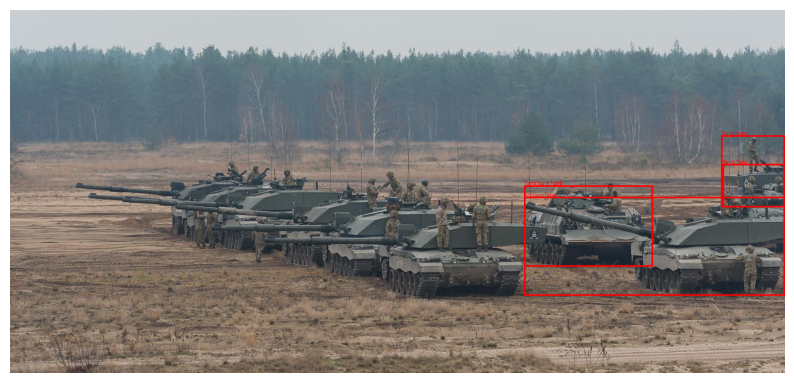

In [10]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def plot_bounding_boxes_pil(image, bboxes, labels=None, scores=None):
    """
    Plots bounding boxes on a PIL image.

    Args:
        image (PIL.Image.Image): The loaded image.
        bboxes (list): List of bounding boxes in [x_min, y_min, x_max, y_max] format.
        labels (list): List of labels corresponding to each bounding box (optional).
        scores (list): List of confidence scores corresponding to each bounding box (optional).
    """
    # Convert the image to an editable format
    draw = ImageDraw.Draw(image)
    
    for i, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max = bbox

        # Draw the bounding box
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

        # Create label text (if provided)
        if labels or scores:
            text = ""
            if labels:
                text += labels[i]
            if scores:
                text += f" {scores[i]:.2f}"
            
            # Draw the label text
            text_position = (x_min, y_min - 10 if y_min > 10 else y_min + 10)
            draw.text(text_position, text, fill="red")

    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Example Usage
# bboxes = [
#     [50, 50, 200, 200],  # Example bounding boxes
#     [150, 100, 300, 250]
# ]
# labels = ["cat", "dog"]
# scores = [0.95, 0.89]

plot_bounding_boxes_pil(image, bboxes, labels)


In [13]:
!pip install peft
!pip install roboflow
!pip install supervision

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 32.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.5 MB/s eta 0:00:00a 0:00:01


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [11]:
import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

# from google.colab import userdata
# from IPython.core.display import display, HTML
from IPython.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

In [12]:
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image
     

In [13]:
BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = f"/home/csegpuserver/Kushagra/Dataset/FF.jsonl",
    image_directory_path = f"/home/csegpuserver/Kushagra/Dataset/Images"
)
val_dataset = DetectionDataset(
    jsonl_file_path = f"/home/csegpuserver/Kushagra/Dataset/FF.jsonl",
    image_directory_path = f"/home/csegpuserver/Kushagra/Dataset/Images"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [14]:
# REVISION = 'refs/pr/6'

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    # revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 4,133,576 || all params: 833,118,920 || trainable%: 0.4962


You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.


In [15]:
torch.cuda.empty_cache()
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [16]:
inputs = inputs.to(torch.float16)  # Convert inputs to float16
model = model.to(torch.float32)  # Convert model to float32 if you don't need mixed precision

In [19]:
def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to redner model response')
    return f"""

    
    {html.escape(json.dumps(response))}

"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

# render_inference_results(peft_model, val_dataset, 4)

In [ ]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 6)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

In [ ]:
%%time

EPOCHS = 10
LR = 5e-5

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

failed to redner model response
failed to redner model response
failed to redner model response
failed to redner model response
failed to redner model response
failed to redner model response


Training Epoch 1/10:   0%|          | 1/1422 [00:01<45:48,  1.93s/it]

Training Epoch 1/10: 100%|██████████| 1422/1422 [44:22<00:00,  1.87s/it]


Average Training Loss: 1.1931801092943226


Validation Epoch 1/10: 100%|██████████| 1422/1422 [23:12<00:00,  1.02it/s]


Average Validation Loss: 1.9207640915228847
failed to redner model response
failed to redner model response
failed to redner model response
failed to redner model response
failed to redner model response
failed to redner model response


Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
Training Epoch 2/10: 100%|██████████| 1422/1422 [44:22<00:00,  1.87s/it]


Average Training Loss: 0.9649841189803621


Validation Epoch 2/10: 100%|██████████| 1422/1422 [23:13<00:00,  1.02it/s]


Average Validation Loss: 1.7734766538594176
failed to redner model response
failed to redner model response
failed to redner model response
failed to redner model response
failed to redner model response
failed to redner model response


Training Epoch 3/10:  11%|█         | 151/1422 [04:42<39:26,  1.86s/it]

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


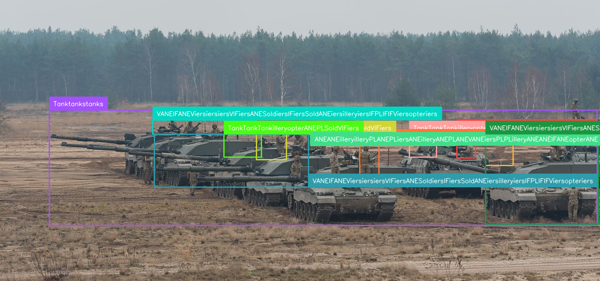

In [61]:
url = "https://imageio.forbes.com/specials-images/imageserve/5ee6b28ac0e4020006640318//0x0.jpg?format=jpg&crop=3000,1407,x0,y451,safe&width=1440"
image = Image.open(requests.get(url, stream=True).raw)
task = "<OD>"
text = "tanks"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = peft_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image